# RECONSTRUCTNIG NOISY IMAGES USING DENOISING AUTOENCODER

_**Building a denoising stacked autoencoder to reconstruct noisy images.**_

## Importing Packages

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

2025-12-07 12:53:10.173990: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-07 12:53:10.174461: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-07 12:53:10.228112: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-07 12:53:11.412912: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

## Data Acquisition & Analysis

In [2]:
# Loads the Fashion dataset into train and test set. This is a dataset of 60,000 28x28 grayscale
# images of 10 fashion categories, along with a test set of 10,000 images
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
# Checks the datatype of train set
X_train_full.dtype

dtype('uint8')

Text(0.5, 0.98, 'Fashion Items')

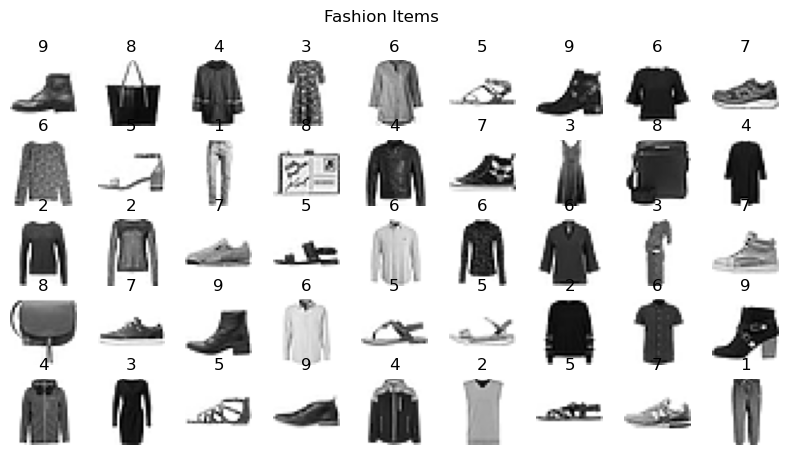

In [4]:
# Shows some of the fashion items as random samples

ROWS = 5
COLUMNS = 9

fig,ax = plt.subplots(ROWS, COLUMNS, figsize = (10,5))     # Figure to contain subplots in 5-rows and 9-columns arrangement
ax = ax.ravel()                                 # Flattens the axes allowing accessing each axis contiguously
for i in range(ROWS * COLUMNS):
  rand = np.random.randint(0, len(X_train_full)) # Generate an index randomly to be used for random item selection
  image = X_train_full[rand]                    # Gets an image indexed by the random number generated in previous step
  ax[i].imshow(image, cmap = 'binary')          # Shows the image
  ax[i].set_title(y_train_full[rand])           # Sets the class of the image as title to be shown in the figure
  ax[i].axis("off")                             # Set the axis off for being non-relevant in this case

fig.suptitle("Fashion Items")                   # Sets title of the figure

## Data Preparation

In [5]:
# Considering the datatype, values get normalized in range 0 — 1 by dividing each value by 255

X_train_full = X_train_full / 255.
X_test = X_test / 255.

In [6]:
# Separates validation set from full train set stratifically

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=10_000, random_state=42, stratify=y_train_full)

## Modeling

### Modeling Denoising Stacked Autoencoder using Dropout

In [7]:
tf.random.set_seed(42)      # Sets the global random seed for operations that rely on a random seed

In [8]:
# Creates a stacked encoder using sequential model
dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),          # Flattens 2D images into 1D
    tf.keras.layers.Dropout(0.5),       # Randomly switches off input to simulate effect of noise in this case. This layer affects input only during training.
                                        # Other alternative to Dropout layer is tf.keras.layers.GaussianNoise.
    tf.keras.layers.Dense(100, activation="relu"),  # 100-output dense layer with ReLu activation
    tf.keras.layers.Dense(30, activation="relu")    # 30-output dense layer with ReLu activation
])

2025-12-07 13:01:19.877213: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
# Similarly, creates a mirrored stacked decoder using sequential model
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),     # Number of output units depends on total number of pixel to restore image into
    tf.keras.layers.Reshape([28, 28])   # Converts 1D output back to 2D as original image dimension
])

In [10]:
# Combines both encoder and decoder as an autoencoder model
dropout_autoencoder = tf.keras.Sequential([dropout_encoder, dropout_decoder])

# Compiles the model
dropout_autoencoder.compile(
    loss="mse", optimizer="nadam")  # metrics are optional as optimization will be based on loss function provided

In [11]:
# Fits the autoencoder
history = dropout_autoencoder.fit(
    X_train, X_train,   # Both features and target will generally be same for autoencoder
    validation_data=(X_val, X_val),     # Validation to be used for measure performance over each epoch
    epochs=100,         # Larger epochs due to early stopping callback setup
    callbacks=[
        # Early stopping callback to stop training after certrain training iterations with no performance improvement and to return the best model so far
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
        ])

Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0292 - val_loss: 0.0217
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0222 - val_loss: 0.0199
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0210 - val_loss: 0.0188
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0202 - val_loss: 0.0184
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0198 - val_loss: 0.0178
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0194 - val_loss: 0.0176
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0191 - val_loss: 0.0173
Epoch 8/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0189 - val_loss: 0.0171
Epoch 9/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0187 - val_loss: 0.0168
Epoch 10/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0186 - val_loss: 0.0167
Epoch 11/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0184 - val_loss: 0.0166
Epoch 12/100
1563/

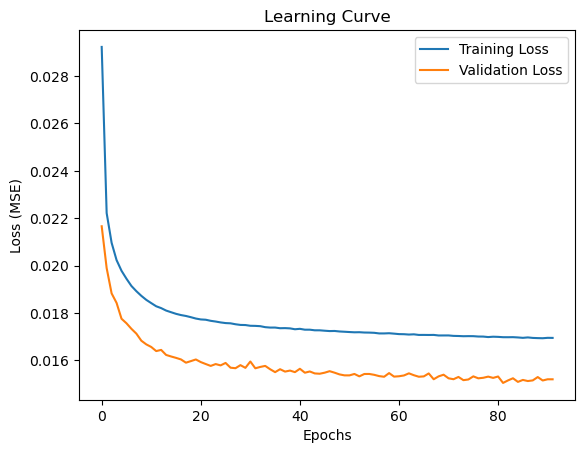

In [12]:
# Visualizing learning curve

plt.plot(history.history["loss"], label="Training Loss")        # Plots training loss
plt.plot(history.history["val_loss"], label="Validation Loss")  # Plots validation loss
plt.xlabel("Epochs")                                            # Sets label for x-axis
plt.ylabel("Loss (MSE)")                                        # Sets label for y-axis
plt.legend()                                                    # Enables legends to be shown
plt.title("Learning Curve")                                     # Sets the title of the plot

plt.show()                                                      # Finally, shows the plot

## Evaluation

### Visualizing Performance of Denoising Autoencoder

In [ ]:
# Adds random noise to all the images in the test set using dropout layer
dropout_layer = tf.keras.layers.Dropout(0.5)
X_test_noisy = dropout_layer(X_test, training=True)

In [14]:
# Now, reconstructs noisy images by passing them through decoder
reconstructed_test_images = dropout_autoencoder(X_test_noisy)

Text(0.5, 0.98, 'Sie-by-Side Visual Comparison between Noisy and Reconstructed Images')

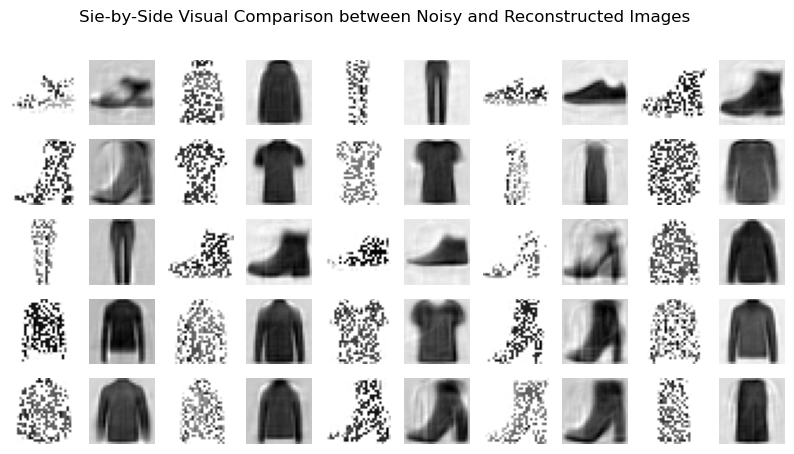

In [18]:
# Shows few of randomly selected reconstructed images

fig,ax = plt.subplots(5,10,figsize = (10,5))

ax = ax.ravel()

for i in range(25):
    rand = np.random.randint(0,len(X_test))
    noisy_image = X_test_noisy[rand]
    reconstructed_image = reconstructed_test_images[rand]

    ax[i*2].imshow(noisy_image, cmap = 'binary')
    ax[i*2].axis("off")
    
    ax[i*2 + 1].imshow(reconstructed_image, cmap = 'binary')
    ax[i*2 + 1].axis("off")

fig.suptitle("Sie-by-Side Visual Comparison between Noisy and Reconstructed Images")

## Observations

- Immediately after flattening the inputs, dropout layer was used to randomly switch off input to simulate effect of noise in the images. This layer affects input only during training. Other alternative to random input dropout is Gaussian noise to be added into inputs.

- The architecture of a stacked autoencoder is typically symmetrical with regard to the central hidden layer (the coding layer). The encoder is like a pyramid in structure with decreasing number of output units in the dense layers and decoder is like a inverted pyramid with increasing number of output units in the dense layer.

- The autoencoder model was compiled with loss function and an optimizer without any specified metrics as the model was to be optimized based on loss function provided. Then the model was fitted over early stopping with the option of restoration of best weights.

- Noise in the test images were added using dropout layer at 50% dropout rate and then were passed through the autoencoder to get those noisy images restored. Then the denoising performance was observed visually by plotting the restored images. 